Using TensorFlow backend.
D:\install_software\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\install_software\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\install_software\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\install_software\anaconda\lib\site-packages\tensorflow\python\fra

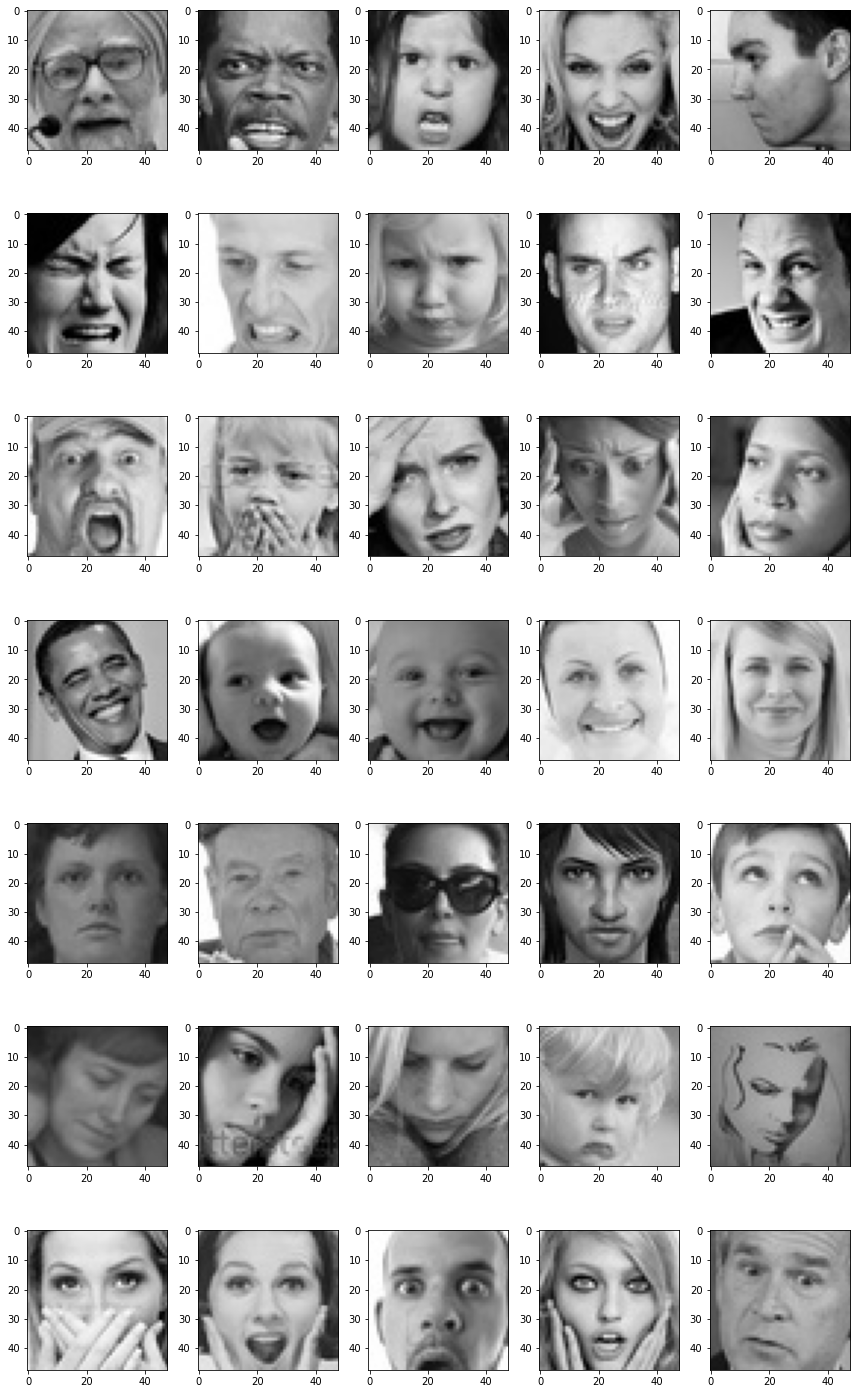

In [1]:
import numpy as np
import seaborn as sns
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import os

# size of the image: 48*48 pixels
pic_size = 48

# input path for the images
base_path = "fer2013/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train/"):
    for i in range(1,6):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [2]:
for expression in os.listdir(base_path + "train"):
    print(str(len(os.listdir(base_path + "train/" + expression))) + " " + expression + " images")

3993 angry images
436 disgust images
4103 fear images
7164 happy images
4982 neutral images
4938 sad images
3205 surprise images


In [3]:
from keras.preprocessing.image import ImageDataGenerator

# number of images to feed into the NN for every batch
batch_size = 128

datagen_train = ImageDataGenerator()
datagen_validation = ImageDataGenerator()

train_generator = datagen_train.flow_from_directory(base_path + "train",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

validation_generator = datagen_validation.flow_from_directory(base_path + "validation",
                                                    target_size=(pic_size,pic_size),
                                                    color_mode="grayscale",
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [7]:
from keras.layers import Dense, Input, Dropout, GlobalAveragePooling2D, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam

# number of possible label values
nb_classes = 7

# Initialising the CNN
model = Sequential()

# 1 - Convolution
model.add(Conv2D(64,(3,3), padding='same', input_shape=(48, 48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 3rd Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 4th Convolution layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(nb_classes, activation='softmax'))

opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
%%time

# number of epochs to train the NN
epochs = 50

from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(generator=train_generator,
                                steps_per_epoch=train_generator.n//train_generator.batch_size,
                                epochs=epochs,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.n//validation_generator.batch_size,
                                callbacks=callbacks_list
                                )

In [ ]:
# serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [ ]:


# plot the evolution of Loss and Acuracy on the train and validation sets

import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()



In [ ]:


# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=validation_generator)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = validation_generator.classes
class_names = validation_generator.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

